# Evaluation of dataset encoding method and model selection

Main tasks are:  
- create custom data preprocessing classes which can be used in pipelines
- get hands-on experience in constructing pipelines to prepare data for training and evaluating models
- test different preprocessing pipelines (WoE, simply encoded, mixed, etc.) and choose the best preprocessing strategy
- evaluate metrics values to compare model types

In [1]:
from datetime import datetime, timedelta

import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

import sklearn as skl
print('Scikit-learn version:', skl.__version__)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

from sklearn import clone

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, precision_recall_fscore_support,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.dummy import DummyClassifier

from tqdm import tqdm

from boruta import BorutaPy

from copy import deepcopy

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1
Scikit-learn version: 1.1.3


In [2]:
from preprocess_classes import (
    DFDropColumns, DFWoeEncoder, DFColumnBinning, DFValuesMapper, DFFuncApplyCols,
    DFCrossFeaturesImputer, DFOneHotEncoder, DFOrdinalEncoder, DFValuesReplacer
)

In [3]:
"""
import logging
import sys

logger = logging.getLogger(__name__) # create handler only, from classes use getLogger(<name>)
logger.setLevel(logging.DEBUG)

handler = logging.StreamHandler(stream=sys.stdout)
handler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(name)s.%(funcName)s: %(levelname)s] %(message)s'))
logger.addHandler(handler)
"""

"\nimport logging\nimport sys\n\nlogger = logging.getLogger(__name__) # create handler only, from classes use getLogger(<name>)\nlogger.setLevel(logging.DEBUG)\n\nhandler = logging.StreamHandler(stream=sys.stdout)\nhandler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(name)s.%(funcName)s: %(levelname)s] %(message)s'))\nlogger.addHandler(handler)\n"

In [4]:
results_filename = 'datasets/processed/results.csv'

## Utility functions definition

In [5]:
class ResultsDF():
    def __init__(self, filename='datasets/processed/results.csv') -> None:
        self._columns = ['type', 'params', 'accuracy', 'precision', 'recall', 'auc', 'preproc_descr']
        self._filename = filename
        self._df = None
        try:
            self._df = pd.read_csv(filename)
        except FileNotFoundError:
            self._df = pd.DataFrame(columns=self._columns)
        return


    def is_ready(self):
        return self._df is not None


    def save(self, filename=None):
        if self._df is None or self._df.empty:
            print('Not saved (no DataFrame)')
            return False
        if filename is None:
            self._df.to_csv(self._filename)
        else:
            self._df.to_csv(filename)
        return True


    def append(self, **kwargs):
        if kwargs == {}:
            return False
        row = {}
        for key, value in kwargs.items():
            if key in self._df.columns:
                row[key] = [value]
        if len(row) > 0:
            self._df = pd.concat([self._df, pd.DataFrame(row, columns=self._columns)], axis=0, ignore_index=True)


In [6]:
# calculating real missing data ratio considering missing-like values (nan-equivalents)
def print_real_nans_ratio(df, cat_nan_equiv='unknown', num_nan_equiv=999):
    print(f'Calculating real NaNs ratio using `{str(cat_nan_equiv)}` and `{str(num_nan_equiv)}` keyvalues:')
    print('Column (value) \tNvalues \tRatio')
    print('-'*40)
    for col in df.columns:
        if df[col].dtype == 'object':
            nan_equiv = cat_nan_equiv
        else:
            nan_equiv = num_nan_equiv
        if nan_equiv in list(df[col]):
            freq_table = df[col].value_counts()
            print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

In [7]:
def preprocess_data(df=None, filename=None, y=None, target='y', pipeline=None, fit=False):
    """
    1. Loads data from file (if DataFrame is not loaded earlier)
    2. Splits DataFrame to target and predictors (if y not passed directly)
    3. Preprocess data using pipeline with ability to toggle fit stage
    """
    if df is None:
        if filename is None:
            raise ValueError('No filename passed')
        df_mod = pd.read_csv(filename)
    else:
        df_mod = df.copy()
    if (y is None) and (target in df_mod.columns):
        y_mod = pd.to_numeric(df_mod[target].map({'yes': 1, 'no': 0}))
        df_mod = df_mod.drop(columns=target)
    else:
        y_mod = y.copy()
    if pipeline is not None:
        if fit:
            df_mod = pipeline.fit_transform(df_mod, y_mod)
        else:
            df_mod = pipeline.transform(df_mod)
    return (df_mod, y_mod)

## Loading train and test data

In [8]:
import_filename = 'datasets/bank-train.csv'
df = pd.read_csv(import_filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp.var.rate    28831 non-null  float64
 16  cons.price.idx  28831 non-null  float64
 17  cons.conf.idx   28831 non-null 

In [9]:
df.head(8)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
4,25,services,single,high.school,no,no,no,cellular,may,thu,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes
5,52,technician,married,basic.6y,unknown,no,no,cellular,may,thu,...,3,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
6,29,technician,single,university.degree,no,yes,no,cellular,jun,wed,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2,no
7,42,technician,married,professional.course,unknown,no,no,cellular,jul,mon,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no


In [10]:
# missing-like values
cat_nan_equiv = 'unknown'
num_nan_equiv = 999

In [11]:
print_real_nans_ratio(df, cat_nan_equiv, num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


In [12]:
df_test = pd.read_csv('datasets/bank-test.csv')

In [13]:
print_real_nans_ratio(df, cat_nan_equiv, num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


## Construct preprocessing pipelines

In [14]:
# definition of inputs for binning and encoding
age_bins = pd.IntervalIndex.from_breaks(np.arange(15, 110, 10))
pdays_bins = pd.IntervalIndex.from_breaks([-1, 3, 6, 13, 50, 999], closed='right')
default_map = {'yes': 1, 'no': 0, 'unknown': 0}
housing_map = {'yes': 1, 'no': 0, 'unknown': 1}
loan_map = {'yes': 1, 'no': 0, 'unknown': 0}
contact_map = {'cellular': 1, 'telephone': 0}
month_map = {'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
dow_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
poutcome_map = {'nonexistent': 0, 'success': 1, 'failure': -1}

# cutoff functions
cutoff_campaign = (lambda x: np.min([x, 6])) # value 6 was calculated in 2_eda for `campaign` feature as cutoff value
cutoff_previous = (lambda x: np.min([x, 3])) # value 3 was calculated in 2_eda for `previous` feature as cutoff value
cutoff_pdays = (lambda x: np.min([13, x])) # value 13 was calculated in 2_eda for `pdays` feature as cutoff value
binarize_pdays = (lambda x: int(x < 999)) # transforming to answer on question: was there a previous contact?

In [15]:
# Preprocessing #1 - using WoE for all columns
preproc_woe_allcols = [
    'WOE for all columns, no imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins, 'pdays': pdays_bins}, new_names=['age_bins', 'pdays_bins'])),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'age_bins', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays_bins'
            ], encode_nans=True, nan_equiv='unknown'
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous
        })),
        ('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=999)),
        ('drop_cols', DFDropColumns(columns=['age', 'duration', 'pdays'])), # try to drop columns with high correlation (`nr.employed` and `emp.var.rate`)
        #('scale', MinMaxScaler())
    ])
]

In [16]:
# Preprocessing #2 - using WoE for all columns + drop high corr
preproc_woe_allcols_dropcorr = [
    'WOE for all columns, no imputing, cutoff, drop high corr',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins, 'pdays': pdays_bins}, new_names=['age_bins', 'pdays_bins'])),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'age_bins', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays_bins'
            ], encode_nans=True, nan_equiv='unknown'
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous
        })),
        ('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=999)),
        ('drop_cols', DFDropColumns(columns=['age', 'duration', 'pdays', 'nr.employed', 'emp.var.rate'])),
        #('scale', MinMaxScaler())
    ])
]

In [17]:
# Preprocessing #3 - using WoE for all columns + drop high corr + drop low IV
preproc_woe_allcols_dropcorr_droplowiv = [
    'WOE for all columns, no imputing, cutoff, drop high corr, drop low IV features',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins, 'pdays': pdays_bins}, new_names=['age_bins', 'pdays_bins'])),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'age_bins', 'job', 'marital', 'education', 'default', 'contact', 'month', 'poutcome', 'pdays_bins'
            ], encode_nans=True, nan_equiv='unknown'
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous
        })),
        ('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=999)),
        ('drop_cols', DFDropColumns(columns=['age', 'duration', 'pdays', 'nr.employed', 'emp.var.rate', 'day_of_week', 'housing', 'loan'])),
        #('scale', MinMaxScaler())
    ])
]

In [18]:
# Preprocessing #4 - using simple encoding + partial WoE
preproc_enc_woe_part = [
    'encoding, WOE partial, imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(map_values={'contact': contact_map})),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome', #'pdays_bins'
            ], encode_nans=True, nan_equiv=cat_nan_equiv
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous,
            'pdays': cutoff_pdays,
        })),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])), # try to drop columns with high correlation (`nr.employed` and `emp.var.rate`)
    ])
]

In [19]:
# Preprocessing #5 - using simple encoding + partial WoE + drop high corr
preproc_enc_woe_part_dropcorr = [
    'encoding, WOE partial, imputing, cutoff, drop high corr',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(map_values={'contact': contact_map})),
        ('encode_woe_cat', DFWoeEncoder(
            columns=[
                'job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'day_of_week', 'poutcome', #'pdays_bins'
            ], encode_nans=True, nan_equiv=cat_nan_equiv
        )),
        ('cutoff', DFFuncApplyCols(map_func={
            'campaign': cutoff_campaign,
            'previous': cutoff_previous,
            'pdays': cutoff_pdays,
        })),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration', 'nr.employed', 'emp.var.rate'])),
    ])
]

In [20]:
# Preprocessing #6 - using simple encoding only
preproc_ordenconly = [
    'encoding only, imputing, no cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOrdinalEncoder( #col_cats={'column_name': 'auto' | list of array-like}
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        #('cutoff', DFFuncApplyCols(map_func={'campaign': cutoff_campaign, 'previous': cutoff_previous, 'pdays': cutoff_pdays,})),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])), #, 'nr.employed', 'emp.var.rate'
        #('scale', MinMaxScaler())
    ])
]

In [21]:
# Preprocessing #7 - using simple encoding only + drop high corr
preproc_ordenconly_dropcorr = [
    'encoding only, imputing, no cutoff, drop high corr',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOrdinalEncoder( #col_cats={'column_name': 'auto' | list of array-like}
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        #('cutoff', DFFuncApplyCols(map_func={'campaign': cutoff_campaign, 'previous': cutoff_previous, 'pdays': cutoff_pdays,})),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration', 'nr.employed', 'emp.var.rate'])),
        #('scale', MinMaxScaler())
    ])
]

In [22]:
# Preprocessing #8 - using simple encoding + cutoff
preproc_ordenc_cutoff = [
    'encoding only, imputing, cutoff',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOrdinalEncoder( #col_cats={'column_name': 'auto' | list of array-like}
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        ('cutoff', DFFuncApplyCols(map_func={'campaign': cutoff_campaign, 'previous': cutoff_previous, 'pdays': cutoff_pdays,})),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])), #, 'nr.employed', 'emp.var.rate'
        #('scale', MinMaxScaler())
    ])
]

In [23]:
# Preprocessing #9 - using simple encoding only + cutoff + drop high corr
preproc_ordenc_cutoff_dropcorr = [
    'encoding only, imputing, cutoff, drop high corr',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOrdinalEncoder( #col_cats={'column_name': 'auto' | list of array-like}
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        ('cutoff', DFFuncApplyCols(map_func={'campaign': cutoff_campaign, 'previous': cutoff_previous, 'pdays': cutoff_pdays,})),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration', 'nr.employed', 'emp.var.rate'])),
        #('scale', MinMaxScaler())
    ])
]

In [24]:
# Preprocessing #10 - using simple encoding + cutoff + binarize pdays
preproc_ordenc_cutoff_binarizepdays = [
    'encoding only, imputing, cutoff, binarize pdays',
    Pipeline([
        ('binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
        ('cross-impute', DFCrossFeaturesImputer(cross_features={'education': 'job', 'job': 'education', 'marital': 'age_bins'}, nan_equiv=cat_nan_equiv)),
        ('replace_values', DFValuesReplacer(replaces={'default': {cat_nan_equiv: 'no'}, 'housing': {cat_nan_equiv: 'yes'}, 'loan': {cat_nan_equiv: 'no'}, 'pdays': {num_nan_equiv: -1}})),
        ('map_values', DFValuesMapper(
            map_values={
                'contact': contact_map,
                'default': default_map,
                'housing': housing_map,
                'loan': loan_map,
                'month': month_map,
                'day_of_week': dow_map,
                'poutcome': poutcome_map
            }
        )),
        ('cat_encode', DFOrdinalEncoder( #col_cats={'column_name': 'auto' | list of array-like}
            cols_cats={
                'job': 'auto',
                'marital': 'auto',
                'education': 'auto'
            }
        )),
        ('cutoff', DFFuncApplyCols(map_func={'campaign': cutoff_campaign, 'previous': cutoff_previous, 'pdays': binarize_pdays,})),
        #('encode_woe_num', DFWoeEncoder(columns=['campaign', 'previous'], encode_nans=True, nan_equiv=num_nan_equiv)),
        ('drop_cols', DFDropColumns(columns=['age_bins', 'duration'])), #, 'nr.employed', 'emp.var.rate'
        #('scale', MinMaxScaler())
    ])
]

In [25]:
pipelines = [
    preproc_woe_allcols,                        # file opt1
    preproc_woe_allcols_dropcorr, 
    preproc_woe_allcols_dropcorr_droplowiv,
    preproc_enc_woe_part, 
    preproc_enc_woe_part_dropcorr,              # file opt5
    preproc_ordenconly, 
    preproc_ordenconly_dropcorr,
    preproc_ordenc_cutoff, 
    preproc_ordenc_cutoff_dropcorr,
    preproc_ordenc_cutoff_binarizepdays         # file opt10
]
current_pipeline = preproc_woe_allcols

## Preprocessing and saving training and testing sets in separate files

In [31]:
for i, pipeline in enumerate(pipelines):
    print('='*20)
    print('Starting pipeline #{}: '.format(i+1), pipeline[0])
    print('='*20)
    X_train, y_train = preprocess_data(df=df, pipeline=pipeline[1], fit=True)
    # if any column has 'object'/'category' dtype while containing numerical values
    # then change dtype for that column as it was preprocessed into numeric already
    for col in X_train.select_dtypes(include=['object', 'category']).columns:
        X_train[col] = pd.to_numeric(X_train[col])
    print('Train set processed')
    
    X_test, y_test = preprocess_data(df=df_test, pipeline=pipeline[1], fit=False)
    print('Test set processed')

    comment_line = '# Option {}. Preprocessing description: '.format(i+1) + pipeline[0] + '\n'

    f = open('datasets/processed/debug-dmitry-bank-train-encoded-opt{}.csv'.format(i+1), 'a')
    f.write(comment_line)
    pd.concat([X_train, y_train], axis=1).to_csv(f, index=False)
    f.close()
    print('Train set saved to file')

    f = open('datasets/processed/debug-dmitry-bank-test-encoded-opt{}.csv'.format(i+1), 'a')
    f.write(comment_line)
    pd.concat([X_test, y_test], axis=1).to_csv(f, index=False)
    f.close()
    print('Test set saved to file')

Starting pipeline #1:  WOE for all columns, no imputing, cutoff
Train set processed
Test set processed
Train set saved to file
Test set saved to file
Starting pipeline #2:  WOE for all columns, no imputing, cutoff, drop high corr
Train set processed
Test set processed
Train set saved to file
Test set saved to file
Starting pipeline #3:  WOE for all columns, no imputing, cutoff, drop high corr, drop low IV features
Train set processed
Test set processed
Train set saved to file
Test set saved to file
Starting pipeline #4:  encoding, WOE partial, imputing, cutoff
Train set processed
Test set processed
Train set saved to file
Test set saved to file
Starting pipeline #5:  encoding, WOE partial, imputing, cutoff, drop high corr
Train set processed
Test set processed
Train set saved to file
Test set saved to file
Starting pipeline #6:  encoding only, imputing, no cutoff
Train set processed
Test set processed
Train set saved to file
Test set saved to file
Starting pipeline #7:  encoding only, 

## Creating preprocessing option with features selected by BorutaPy

#### Performing initial metrics evaluation with and without using BorutaPy (time-consuming)

In [37]:
boruta_clf = RandomForestClassifier(n_estimators=200, n_jobs=3, max_depth=5)
boruta_selector = BorutaPy(boruta_clf, random_state=42, verbose=0)

In [33]:
"""
BorutaPy returns numpy array without column names
This function performs column-wise comparing of returned array
with initial DataFrame
Returns: list of column names for features returned by BorutaPy
"""
def get_selected_features(array_selected, df_original):
    cols_selected = []
    initial_columns = list(df_original.columns)
    for j in range(array_selected.shape[1]):
        a = array_selected[:, j]
        for col in initial_columns:
            b = df_original[col].to_numpy()
            if np.array_equal(a, b):
                cols_selected.append(col)
                initial_columns.remove(col)
                break
    return cols_selected

In [34]:
classifiers = [
    ('logistic_regression', Pipeline([
            ('scale', MinMaxScaler()),
            ('clf', LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=1000)),
        ])
    ),
    #('naive_bayes', MultinomialNB()), # Doesn't allow negative values
    ('sgd', Pipeline([
            ('scale', MinMaxScaler()),
            ('clf', SGDClassifier(class_weight='balanced', random_state=42, loss='hinge')), # added after evaluation #loss='log_loss'
        ])
    ),
    ('random_forest', RandomForestClassifier(n_estimators=100, class_weight='balanced')),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
]
grid_params = {
    'logistic_regression': {'clf__C': np.logspace(-3, 2, 6)},
    'random_forest': {'max_depth': [x for x in range(2, 7, 2)]},
    'knn': {'n_neighbors': [x for x in range(1, 6)]},
    'sgd': {'clf__loss': ['hinge', 'log_loss']}
}

In [35]:
def get_model_results(model, train_set, test_set=None, show_charts=False):
    metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score, 'auc': roc_auc_score}
    if show_charts:
        if test_set is None:
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[2])
        else:
            fig, axs = plt.subplots(2, 3, figsize=(15, 10))
            conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 0])
            roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 1])
            pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 2])
            conf_matrix_test = ConfusionMatrixDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 0])
            roc_curve_test = RocCurveDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 1])
            pr_curve_test = PrecisionRecallDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 2])
    
    results = {}
    print('Scores:')
    print('Indicator  \tTrain \tTest')
    print('='*40)
    for m_name, m_func in metrics.items():
        results[m_name] = {} 
        results[m_name]['train'] = m_func(train_set[1], model.predict(train_set[0]))
        if test_set is not None:
            results[m_name]['test'] = m_func(test_set[1], model.predict(test_set[0]))
        print('{}:     \t{:.4f} \t{:.4f}'.format(m_name, results[m_name]['train'], 0.0 if test_set is None else results[m_name]['test']))
    
    return results

In [39]:
records = []
trained_classifiers = {}
rec_n = -1
opt_names = ['original', 'selected']
for i, pipeline in enumerate(pipelines):
    print('='*20)
    print('Starting pipeline #{}: '.format(i+1), pipeline[0])
    print('='*20)
    X_train, y_train = preprocess_data(df=df, pipeline=pipeline[1], fit=True)
    for col in X_train.select_dtypes(include=['object', 'category']).columns:
        X_train[col] = pd.to_numeric(X_train[col])
    base_cols = list(X_train.columns)
    print('Training set ready')

    X_test, y_test = preprocess_data(df=df_test, pipeline=pipeline[1], fit=False)
    for col in X_test.select_dtypes(include=['object', 'category']).columns:
        X_test[col] = pd.to_numeric(X_test[col])
    print('Testing set ready')
    
    # Commented out because columns are already defined from previous run and are contained in eval_results
    print('Starting feature selection using Boruta')
    X_train_selected = boruta_selector.fit_transform(X_train.to_numpy(), y_train.to_numpy())
    sel_cols = get_selected_features(X_train_selected, X_train)
    # Commented rows are used when there is already loaded data defined from previous run contained in eval_results
    #str_features = eval_results[(eval_results['feat_type'] == 'selected') & (eval_results['pipeline_id'] == i)].iloc[0]['features']
    #sel_cols = [x.strip()[1:-1] for x in str_features[1:-1].split(',')]
    #X_train_selected = X_train[sel_cols].to_numpy()
    X_test_selected = X_test[sel_cols].to_numpy()
    
    train_sets = [(X_train, y_train), (X_train_selected, y_train)]
    test_sets = [(X_test, y_test), (X_test_selected, y_test)]
    col_options = [base_cols, sel_cols]

    print('Feature selection finished')

    for clf in classifiers:
        print('\tEvaluating with ', clf[0])
        for opt_name, cols, train_set, test_set in zip(opt_names, col_options, train_sets, test_sets): #[((X_train, y_train), (X_test, y_test), base_cols, column_options[0]), ((X_train_selected, y_train), (X_test_selected, y_test), sel_cols)]:
            feat_train, target_train = train_set
            feat_test, target_test = test_set
            clf_grid = GridSearchCV(estimator=clf[1], param_grid=grid_params[clf[0]], scoring='recall', cv=5, return_train_score=True)
            clf_grid.fit(feat_train, target_train)
            #clf[1].fit(feat_train, target_train)
            results = get_model_results(clf_grid.best_estimator_, train_set=[feat_train, target_train], test_set=[feat_test, target_test], show_charts=False)
            #results[m_name]['train']
            trained_classifiers[clf[0]+'_'+opt_name] = deepcopy(clf_grid.best_estimator_)
            for m_name, m_dict in results.items():
                for m_type, val in m_dict.items():
                    #rec_n += 1
                    records.append(
                        {
                            'pipeline_id': i,
                            'pipeline_descr': pipeline[0],
                            'clf_type': clf[0],
                            'features': cols,
                            'feat_type': opt_name,
                            'metric_name': m_name,
                            'metric_type': m_type,
                            'metric_val': val
                        }
                    )


Starting pipeline #1:  WOE for all columns, no imputing, cutoff
Training set ready
Testing set ready
Starting feature selection using Boruta
Feature selection finished
	Evaluating with  logistic_regression
Scores:
Indicator  	Train 	Test
accuracy:     	0.7301 	0.7379
precision:     	0.2493 	0.2613
recall:     	0.6940 	0.7263
f1:     	0.3668 	0.3843
auc:     	0.7143 	0.7328
Scores:
Indicator  	Train 	Test
accuracy:     	0.7246 	0.7306
precision:     	0.2460 	0.2561
recall:     	0.6995 	0.7306
f1:     	0.3640 	0.3793
auc:     	0.7136 	0.7306
	Evaluating with  sgd
Scores:
Indicator  	Train 	Test
accuracy:     	0.7499 	0.7521
precision:     	0.2671 	0.2730
recall:     	0.6998 	0.7220
f1:     	0.3867 	0.3962
auc:     	0.7280 	0.7390
Scores:
Indicator  	Train 	Test
accuracy:     	0.8315 	0.8355
precision:     	0.3557 	0.3677
recall:     	0.6108 	0.6401
f1:     	0.4496 	0.4671
auc:     	0.7352 	0.7502
	Evaluating with  random_forest
Scores:
Indicator  	Train 	Test
accuracy:     	0.8185 	0.821

In [116]:
import json
# Serializing json
records_serialized = json.dumps(records, indent=4)
 
# Writing to sample.json
with open('datasets/evaluation_results.json', 'w') as outfile:
    outfile.write(records_serialized)

len(records)

600

In [40]:
df_eval = pd.DataFrame(records)
df_eval

,pipeline_id,pipeline_descr,clf_type,features,feat_type,metric_name,metric_type,metric_val
0,0,"WOE for all columns, no imputing, cutoff",logistic_regression,"[job, marital, education, default, housing, lo...",original,accuracy,train,0.730117
1,0,"WOE for all columns, no imputing, cutoff",logistic_regression,"[job, marital, education, default, housing, lo...",original,accuracy,test,0.737881
2,0,"WOE for all columns, no imputing, cutoff",logistic_regression,"[job, marital, education, default, housing, lo...",original,precision,train,0.249309
3,0,"WOE for all columns, no imputing, cutoff",logistic_regression,"[job, marital, education, default, housing, lo...",original,precision,test,0.261308
4,0,"WOE for all columns, no imputing, cutoff",logistic_regression,"[job, marital, education, default, housing, lo...",original,recall,train,0.693966
...,...,...,...,...,...,...,...,...
795,9,"encoding only, imputing, cutoff, binarize pdays",knn,"[age, contact, month, day_of_week, previous, p...",selected,recall,test,0.303161
796,9,"encoding only, imputing, cutoff, binarize pdays",knn,"[age, contact, month, day_of_week, previous, p...",selected,f1,train,0.644232
797,9,"encoding only, imputing, cutoff, binarize pdays",knn,"[age, contact, month, day_of_week, previous, p...",selected,f1,test,0.309498
798,9,"encoding only, imputing, cutoff, binarize pdays",knn,"[age, contact, month, day_of_week, previous, p...",selected,auc,train,0.795644


In [41]:
df_eval.to_csv('datasets/processed/evaluation_results_debug.csv', index=False)

#### This section was inserted after initial metrics collection was finished and saved to file

In [44]:
eval_results = pd.read_csv('datasets/processed/evaluation_results.csv', index_col=0)
eval_results['num_features'] = eval_results['features'].apply(lambda x: len(x[1:-1].split(',')))
max_num_features = eval_results.groupby(by=['pipeline_id'])['num_features'].max()
eval_results['feat_type'] = eval_results.apply(lambda x: 'original' if x['num_features'] == max_num_features[x['pipeline_id']] else 'selected', axis=1)
eval_results.sample(20)

,pipeline_id,pipeline_descr,clf_type,features,metric_name,metric_type,metric_val,num_features,feat_type
513,8,"encoding only, imputing, cutoff, drop high corr",random_forest,"['age', 'contact', 'month', 'pdays', 'previous...",precision,test,0.256352,9,selected
459,7,"encoding only, imputing, cutoff",random_forest,"['age', 'contact', 'month', 'day_of_week', 'pd...",auc,test,0.731370,12,selected
18,0,"WOE for all columns, no imputing, cutoff",logistic_regression,"['job', 'contact', 'month', 'day_of_week', 'pr...",auc,train,0.713628,13,selected
426,7,"encoding only, imputing, cutoff",logistic_regression,"['age', 'job', 'marital', 'education', 'defaul...",f1,train,0.360303,19,original
539,8,"encoding only, imputing, cutoff, drop high corr",knn,"['age', 'contact', 'month', 'pdays', 'previous...",auc,test,0.622189,9,selected
541,9,"encoding only, imputing, cutoff",logistic_regression,"['age', 'job', 'marital', 'education', 'defaul...",accuracy,test,0.728980,19,original
238,3,"encoding, WOE partial, imputing, cutoff",knn,"['age', 'job', 'contact', 'month', 'day_of_wee...",auc,train,0.876302,13,selected
0,0,"WOE for all columns, no imputing, cutoff",logistic_regression,"['job', 'marital', 'education', 'default', 'ho...",accuracy,train,0.730117,19,original
354,5,"encoding only, imputing, no cutoff",knn,"['age', 'contact', 'month', 'day_of_week', 'pd...",recall,train,0.636700,12,selected
107,1,"WOE for all columns, no imputing, cutoff, drop...",knn,"['job', 'marital', 'education', 'default', 'ho...",f1,test,0.329912,17,original


In [48]:
eval_results[(eval_results['feat_type'] == 'original') & (eval_results['pipeline_id'] == 0)].iloc[0]['features']

"['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'age_bins', 'pdays_bins']"

In [41]:
[x.strip()[1:-1] for x in eval_results.loc[0, 'features'][1:-1].split(',')]

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'campaign',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'age_bins',
 'pdays_bins']

In [55]:
pd.concat([eval_results.drop(columns=['num_features', 'feat_type']), pd.DataFrame(records)], axis=0).to_csv('datasets/processed/evaluation_results2.csv', index=False)

Text(0.5, 1.0, 'Reaction of different model types on preprocessing strategy')

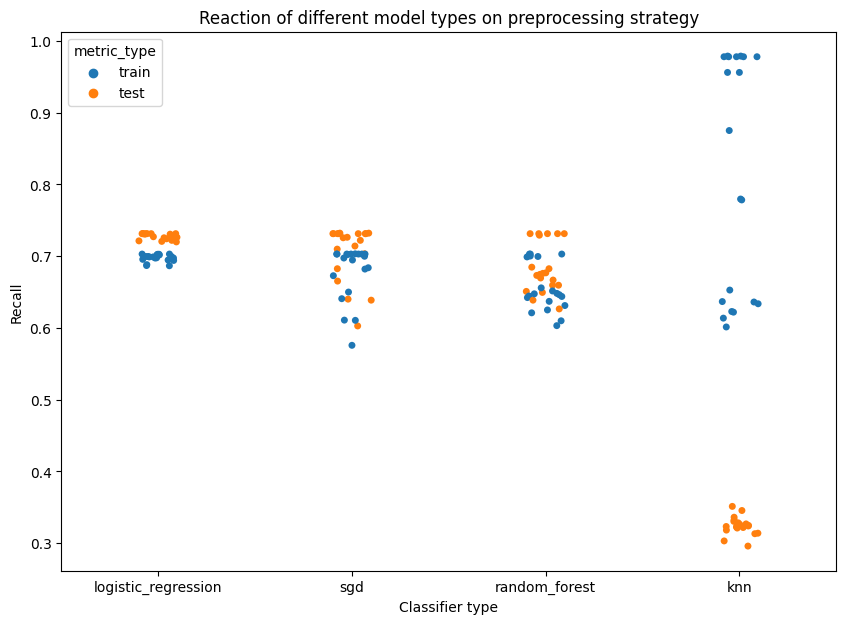

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.stripplot(data=df_eval[df_eval['metric_name']=='recall'], x='clf_type', y='metric_val', hue='metric_type', ax=ax)
ax.set_xlabel('Classifier type')
ax.set_ylabel('Recall')
ax.set_title('Reaction of different model types on preprocessing strategy')

Let's plot the chart to distinguish the difference between preprocessing option and recall value

In [49]:
chart_grouper = df_eval.groupby(by=['metric_name', 'metric_type', 'clf_type', 'feat_type'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


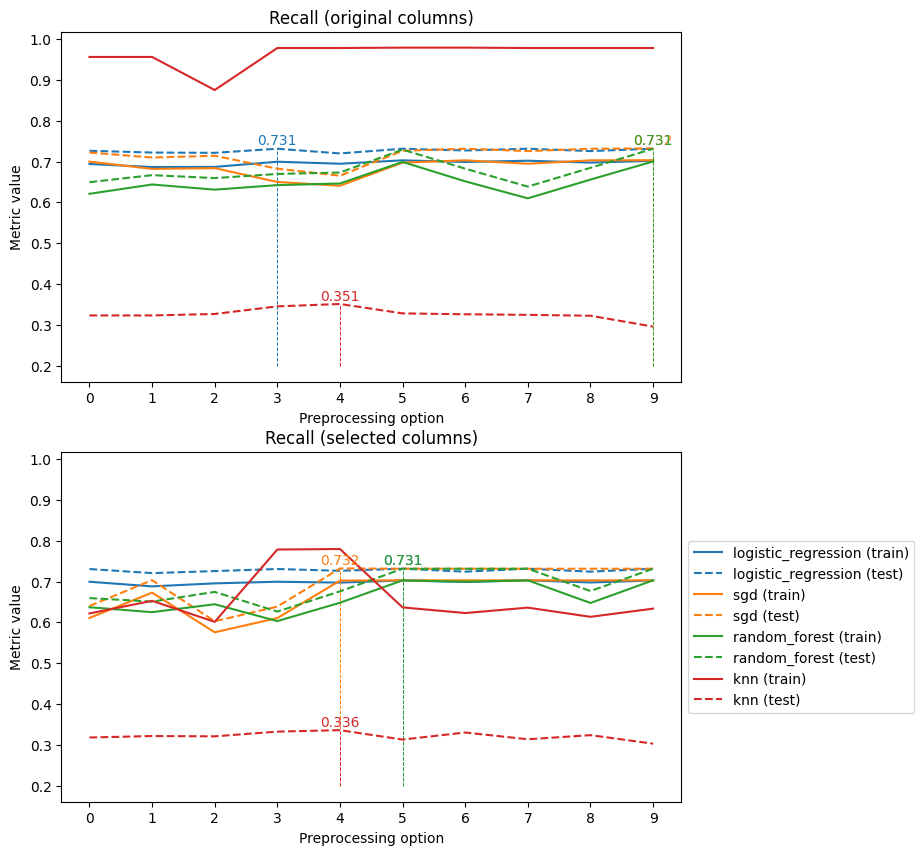

In [55]:
clf_types = list(df_eval['clf_type'].unique())
m_types = ['train', 'test']
f_types = ['original', 'selected']
metrics = ['recall'] #, 'auc'

fig, axs = plt.subplots(len(f_types), len(metrics), figsize=(8*len(metrics), 5*len(f_types)), sharey=True)

for k, metric in enumerate(metrics):
    #ax = axs[k]
    for j, f_type in enumerate(f_types):
        lw = 1.5 #if f_type == 'original' else 2
        if len(metrics) == 1:
            ax = axs[j]
        else:
            ax = axs[j, k]
        for i, clf in enumerate(clf_types):
            color = sns.color_palette()[i]
            for m_type, style in zip(m_types, ['-', '--']):
                label = '{} ({})'.format(clf, m_type) #if j == 0 else '_'
                temp = chart_grouper.get_group((metric, m_type, clf, f_type))
                ax.plot(temp['pipeline_id'], temp['metric_val'], color=color, linestyle=style, lw=lw, label=label)
                if m_type == 'test':
                    idx_max = np.argmax(temp['metric_val'])
                    ax.plot([temp['pipeline_id'].iloc[idx_max], temp['pipeline_id'].iloc[idx_max]], [0.2, temp['metric_val'].max()], color=color, linestyle='--', lw=0.7)
                    ax.annotate(str(np.round(temp['metric_val'].max(), 3)), (temp['pipeline_id'].iloc[idx_max], temp['metric_val'].max()+0.01), ha='center', color=color)
        ax.set_xticks(range(0, 10))
        #ax.set_xticklabels(str(range(0, 10)))
        ax.set_xlabel('Preprocessing option')
        #ax.set_ybound(lower=0.6 if j==0 else 0.55, upper=0.75 if j==0 else 0.8)
        ax.set_ylabel('Metric value')
        ax.set_title('{} ({} columns)'.format(metric.capitalize(), f_type))
        #if j == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend();

## Comparing basic models and dataset preprocessing options

In [ ]:
# just in case I'll forget metrics' names
#skl.metrics.get_scorer_names()

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [41]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'AUC': 'roc_auc', 'Recall': 'recall'}

Scores:
Indicator  	Train 	Test
accuracy:     	0.8970 	0.8984
precision:     	0.6398 	0.6789
recall:     	0.1952 	0.1868
f1:     	0.2991 	0.2930
auc:     	0.5906 	0.5878


{'accuracy': {'train': 0.8969511983628733, 'test': 0.8984381322327426},
 'precision': {'train': 0.6397578203834511, 'test': 0.6788511749347258},
 'recall': {'train': 0.19519704433497537, 'test': 0.1867816091954023},
 'f1': {'train': 0.29912715263033735, 'test': 0.2929577464788732},
 'auc': {'train': 0.5906212325611084, 'test': 0.5877820494677422}}

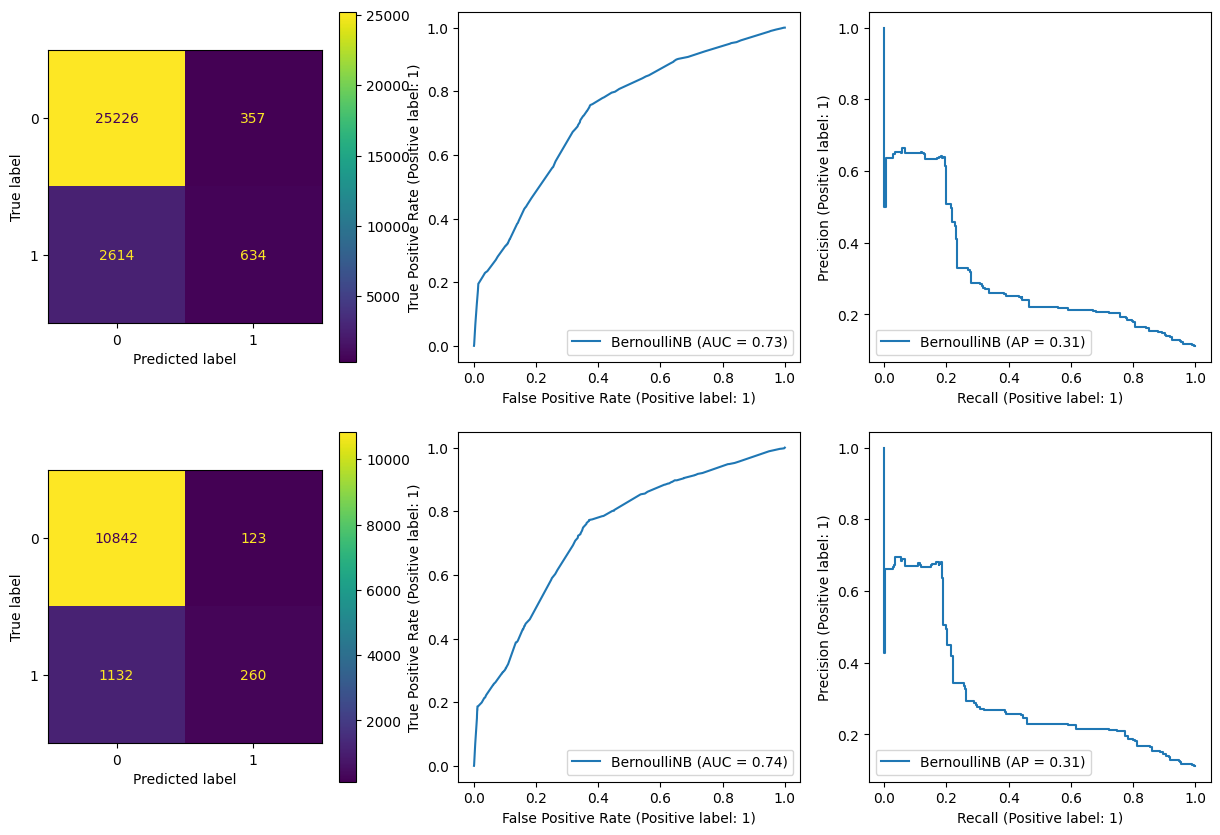

In [44]:
catnb_clf = BernoulliNB(binarize=0.0)
catnb_clf.fit(X_train, y_train)
get_model_results(catnb_clf, train_set=[X_train, y_train], test_set=[X_test, y_test], show_charts=True)

Scores:
Indicator  	Train 	Test
accuracy:     	0.9960 	0.8445
precision:     	0.9658 	0.3126
recall:     	1.0000 	0.3169
f1:     	0.9826 	0.3147
auc:     	0.9978 	0.6142


{'accuracy': 0.9960110995490808,
 'precision': 0.9657992565055762,
 'recall': 1.0,
 'f1': 0.9826021180030257,
 'auc': 0.997752369784032}

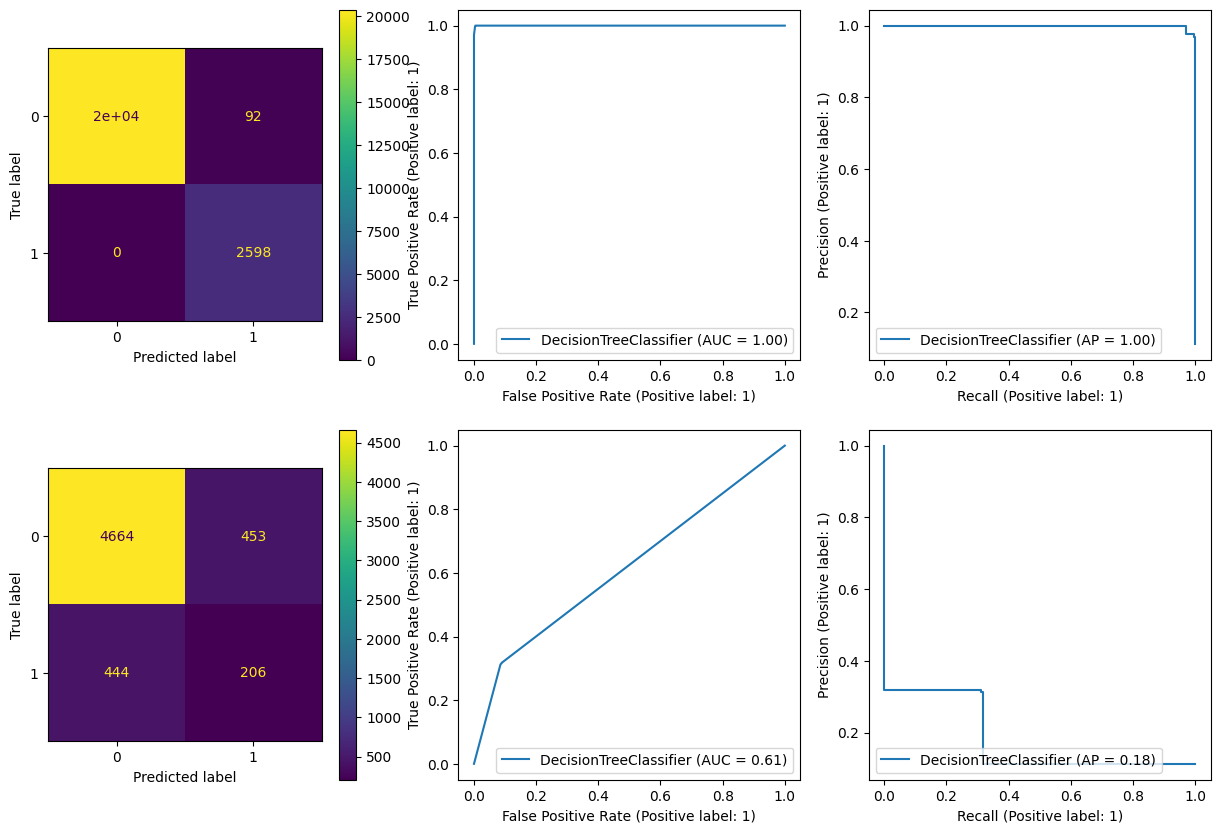

In [34]:
dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_clf.fit(X_train, y_train)
get_model_results(dt_clf, train_set=[X_train, y_train], test_set=[X_val, y_val])

In [38]:
recall = {
    'train': [],
    'val': []
}
auc = {
    'train': [],
    'val': []
}
for depth in range(2, 33):
    dt_clf = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
    dt_clf.fit(X_train, y_train)
    y_pred_train = dt_clf.predict(X_train)
    y_pred_val = dt_clf.predict(X_val)
    recall['train'].append(recall_score(y_true=y_train, y_pred=y_pred_train))
    recall['val'].append(recall_score(y_true=y_val, y_pred=y_pred_val))
    auc['train'].append(roc_auc_score(y_train, y_pred_train))
    auc['val'].append(roc_auc_score(y_val, y_pred_val))


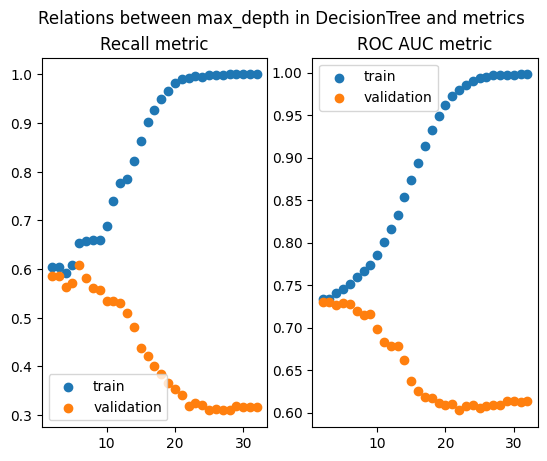

In [40]:
fig, axs = plt.subplots(1, 2)
fig.suptitle('Relations between max_depth in DecisionTree and metrics')
axs[0].scatter(list(range(2, 33)), recall['train'], label='train')
axs[0].scatter(list(range(2, 33)), recall['val'], label='validation')
axs[0].set_title('Recall metric')
axs[0].legend()
axs[1].scatter(list(range(2, 33)), auc['train'], label='train')
axs[1].scatter(list(range(2, 33)), auc['val'], label='validation')
axs[1].set_title('ROC AUC metric')
axs[1].legend();

In [42]:
param_grid = [
    {'max_depth': list(range(2, 33))}
]
dt_grid = GridSearchCV(estimator=dt_clf, param_grid=param_grid, scoring='recall', cv=kfold, return_train_score=True)
dt_grid.fit(X_train, y_train)
grid_res = dt_grid.cv_results_
grid_res

{'mean_fit_time': array([0.03339148, 0.0350939 , 0.04340501, 0.05330238, 0.05859392,
        0.06949749, 0.05910051, 0.06179686, 0.06869452, 0.07329967,
        0.07960486, 0.08090422, 0.08389349, 0.08810296, 0.09210145,
        0.08859572, 0.09240022, 0.09450734, 0.09480371, 0.09410238,
        0.09680111, 0.0993037 , 0.09639754, 0.09599321, 0.09919713,
        0.09640298, 0.09709928, 0.09879763, 0.09919698, 0.09710014,
        0.09869394]),
 'std_fit_time': array([0.01415675, 0.00181705, 0.00269633, 0.00346659, 0.00382855,
        0.00528977, 0.0023083 , 0.00183879, 0.00155038, 0.00223996,
        0.00174153, 0.00220543, 0.00358563, 0.00207698, 0.00393381,
        0.00299263, 0.00341488, 0.0040604 , 0.00227898, 0.00287342,
        0.00386194, 0.00332861, 0.0022927 , 0.00376956, 0.00315196,
        0.00311304, 0.00305124, 0.0044637 , 0.00526739, 0.00421316,
        0.00332276]),
 'mean_score_time': array([0.00440397, 0.00370193, 0.0032932 , 0.00390241, 0.00390155,
        0.00501218, 

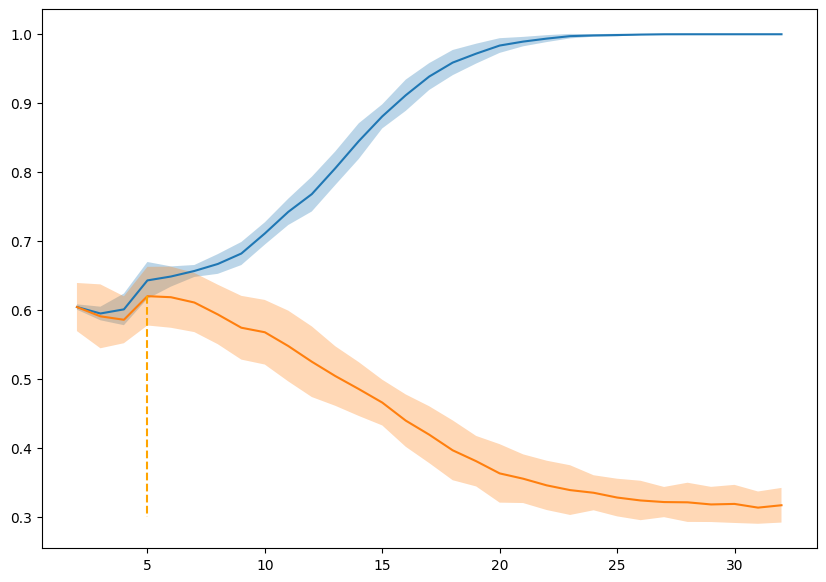

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
axs.plot(np.array(grid_res['param_max_depth'], dtype=int), grid_res['mean_train_score'], label=('train'))
axs.fill_between(np.array(grid_res['param_max_depth'], dtype=int), grid_res['mean_train_score']-grid_res['std_train_score'], grid_res['mean_train_score']+grid_res['std_train_score'], alpha=0.3, label='_')
axs.plot(np.array(grid_res['param_max_depth']), grid_res['mean_test_score'], label=('validate'))
axs.fill_between(np.array(grid_res['param_max_depth'], dtype=int), grid_res['mean_test_score']-grid_res['std_test_score'], grid_res['mean_test_score']+grid_res['std_test_score'], alpha=0.3, label='_')
idx_maxval = np.argmax(grid_res['mean_test_score'])
x_max = grid_res['param_max_depth'][idx_maxval]
axs.plot([x_max, x_max], [grid_res['mean_test_score'][idx_maxval], 0.3], c='orange', ls='--')

### SVM

d:\Work\venv\dsml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Scores:
Indicator  	Train 	Test
accuracy:     	0.7375 	0.7208
precision:     	0.2363 	0.2059
recall:     	0.5962 	0.5169
f1:     	0.3385 	0.2945
auc:     	0.6758 	0.6318


{'accuracy': 0.7374696496704821,
 'precision': 0.23630816170861937,
 'recall': 0.5962278675904542,
 'f1': 0.3384682617720966,
 'auc': 0.6758135331307104}

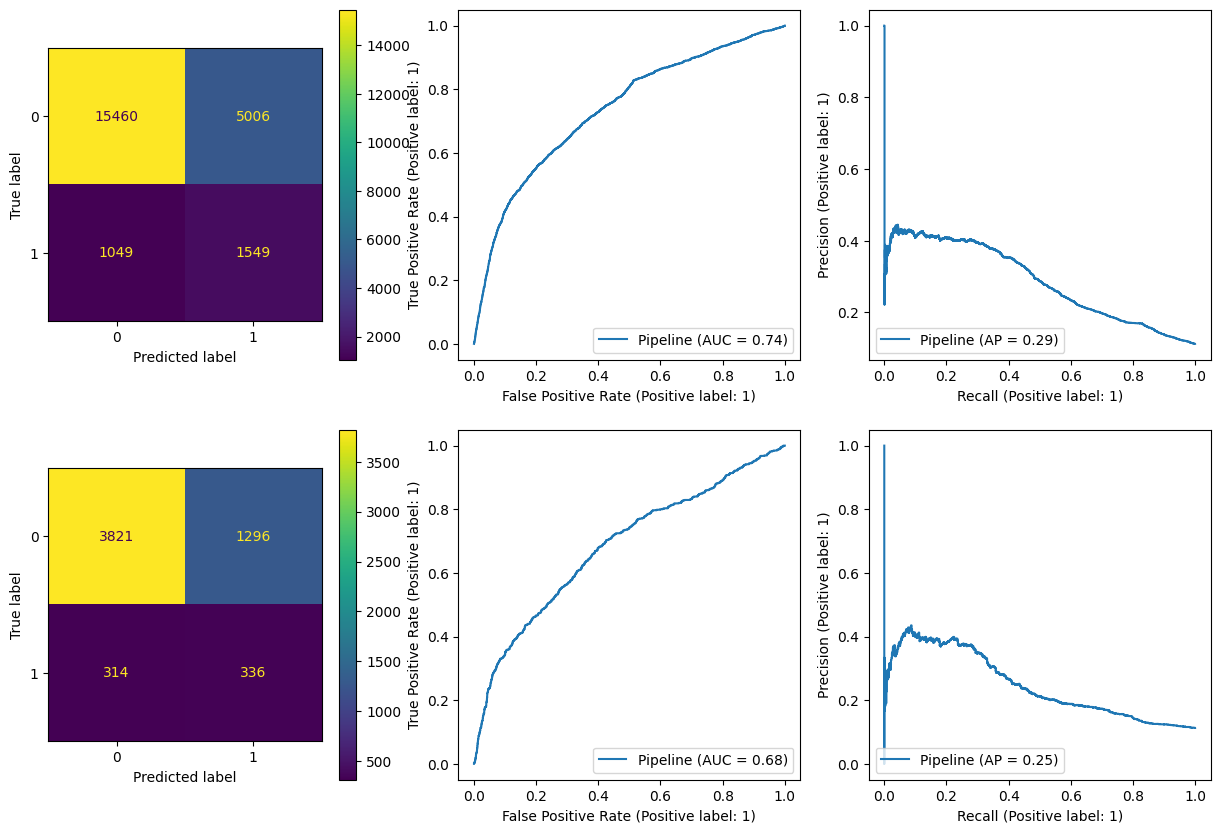

In [90]:
svm_clf = Pipeline([
    ('scale', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=1.0, class_weight='balanced', max_iter=10000)),
])
svm_clf.fit(X_train, y_train)
show_model_results(model=svm_clf, train_set=[X_train, y_train], test_set=[X_val, y_val])

In [ ]:
svm_grid = [
    {'clf__kernel': ['rbf'], 'clf__C': np.logspace(-4, 2, 7), 'clf__gamma': np.logspace(-2, 2, 5)},
    #{'clf__kernel': ['sigmoid'], }
    #{'clf__kernel': ['poly']}
]

In [ ]:
classifiers = [
    LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=1000),
    CategoricalNB(),
    ComplementNB(),
    BernoulliNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=500, class_weight='balanced'),
    KNeighborsClassifier(n_neighbors=3),
    xgb.XGBClassifier(n_estimators=500)
]

In [26]:
baseline_clf = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced')
baseline_cv_clf = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='lbfgs', class_weight='balanced', scoring='recall', max_iter=1000)
classifier = imbPipeline([
    ('scale', MinMaxScaler()),
    #('upsample', SMOTE(random_state=42)),
    ('clf', baseline_cv_clf)
])

In [33]:
classifier.fit(X_train, y_train)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('clf',
                 LogisticRegressionCV(class_weight='balanced', cv=5,
                                      max_iter=1000, scoring='recall'))])

Scores:
Indicator  	Train 	Test
accuracy:     	0.7201 	0.0000
precision:     	0.2428 	0.0000
recall:     	0.7007 	0.0000
f1:     	0.3606 	0.0000
auc:     	0.7116 	0.0000


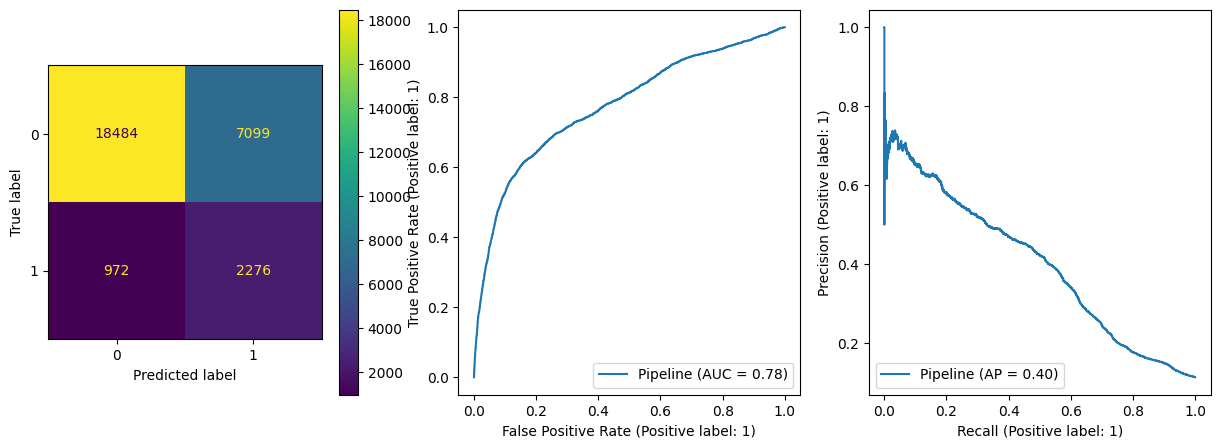

In [34]:
res = show_model_results(classifier, train_set=[X_train, y_train])

We are ready to create procedure to evaluate all pipeline and classifier combinations and save results in DataFrame

In [35]:
#results_df = pd.DataFrame(columns = ['type', 'params', 'accuracy', 'precision', 'recall', 'auc', 'preproc_descr'])
results_df = ResultsDF()

In [36]:
classifiers = [classifier]

 12%|█▎        | 1/8 [00:04<00:29,  4.20s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7215 	0.0000
precision:     	0.2439 	0.0000
recall:     	0.7007 	0.0000
f1:     	0.3618 	0.0000
auc:     	0.7124 	0.0000


 25%|██▌       | 2/8 [00:07<00:22,  3.79s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7344 	0.0000
precision:     	0.2518 	0.0000
recall:     	0.6884 	0.0000
f1:     	0.3687 	0.0000
auc:     	0.7143 	0.0000


 38%|███▊      | 3/8 [00:14<00:24,  4.94s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7201 	0.0000
precision:     	0.2428 	0.0000
recall:     	0.7007 	0.0000
f1:     	0.3606 	0.0000
auc:     	0.7116 	0.0000


 50%|█████     | 4/8 [00:18<00:19,  4.79s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7235 	0.0000
precision:     	0.2447 	0.0000
recall:     	0.6970 	0.0000
f1:     	0.3622 	0.0000
auc:     	0.7119 	0.0000


 62%|██████▎   | 5/8 [00:23<00:14,  4.79s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7174 	0.0000
precision:     	0.2412 	0.0000
recall:     	0.7029 	0.0000
f1:     	0.3591 	0.0000
auc:     	0.7111 	0.0000


 75%|███████▌  | 6/8 [00:27<00:09,  4.51s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7145 	0.0000
precision:     	0.2387 	0.0000
recall:     	0.7010 	0.0000
f1:     	0.3562 	0.0000
auc:     	0.7086 	0.0000


 88%|████████▊ | 7/8 [00:32<00:04,  4.83s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7171 	0.0000
precision:     	0.2410 	0.0000
recall:     	0.7032 	0.0000
f1:     	0.3590 	0.0000
auc:     	0.7110 	0.0000


100%|██████████| 8/8 [00:37<00:00,  4.65s/it]

Scores:
Indicator  	Train 	Test
accuracy:     	0.7195 	0.0000
precision:     	0.2420 	0.0000
recall:     	0.6986 	0.0000
f1:     	0.3595 	0.0000
auc:     	0.7104 	0.0000


,type,params,accuracy,precision,recall,auc,preproc_descr
0,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.721515,0.243866,0.700739,0.712446,"WOE for all columns, no imputing, cutoff"
1,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.734418,0.251773,0.688424,0.714340,"WOE for all columns, no imputing, cutoff, drop..."
2,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.720058,0.242773,0.700739,0.711625,"encoding, WOE partial, imputing, cutoff"
3,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.723457,0.244677,0.697044,0.711928,"encoding, WOE partial, imputing, cutoff, drop ..."
4,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.717388,0.241179,0.702894,0.711061,"encoding only, imputing, no cutoff"
5,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.714474,0.238729,0.701047,0.708613,"encoding only, imputing, no cutoff, drop high ..."
6,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.717110,0.241030,0.703202,0.711039,"encoding only, imputing, cutoff"
7,LogisticRegression,"{'Cs': 10, 'class_weight': 'balanced', 'cv': 5...",0.719538,0.242001,0.698584,0.710391,"encoding only, imputing, cutoff, drop high corr"


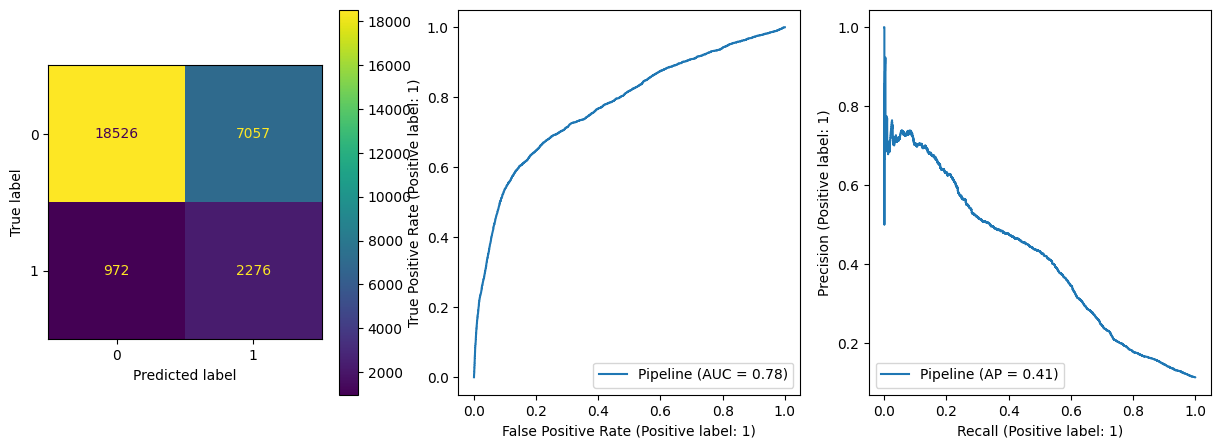

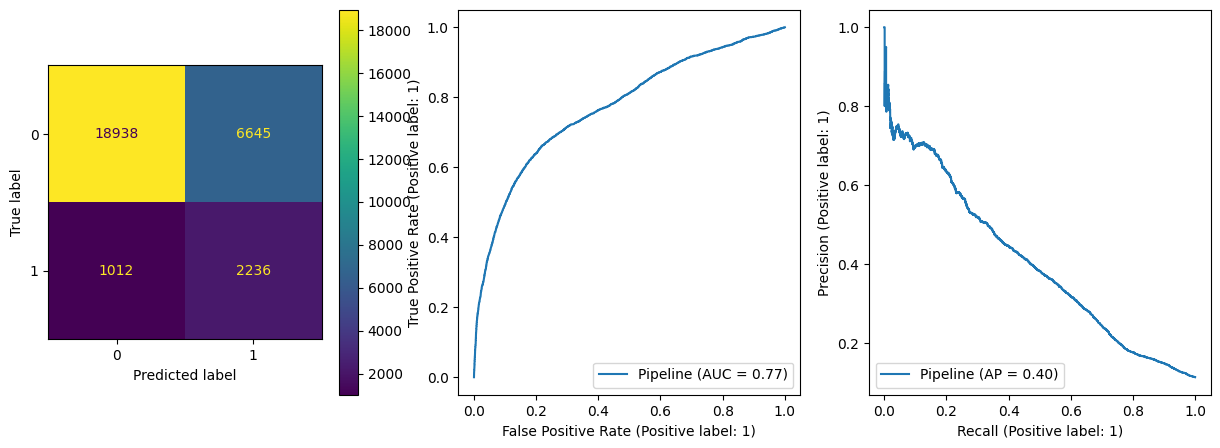

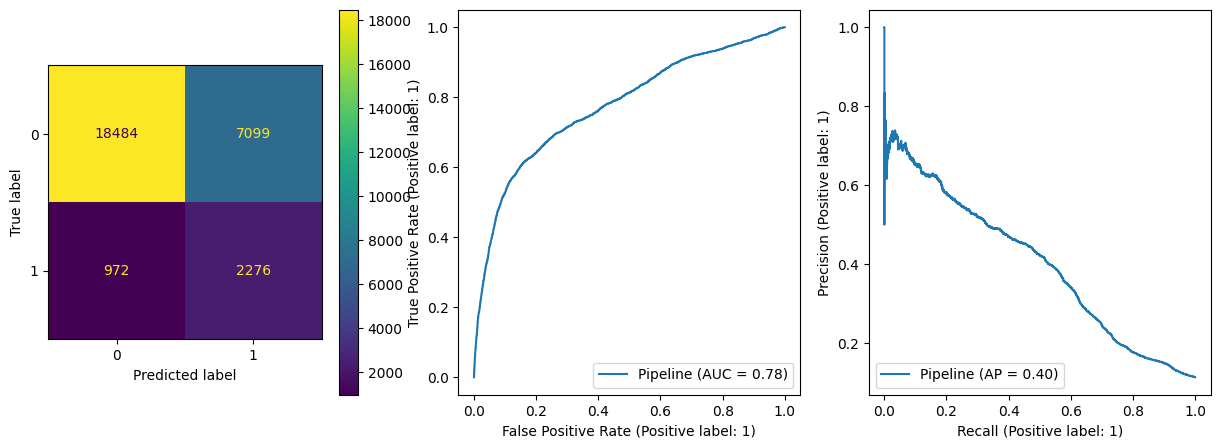

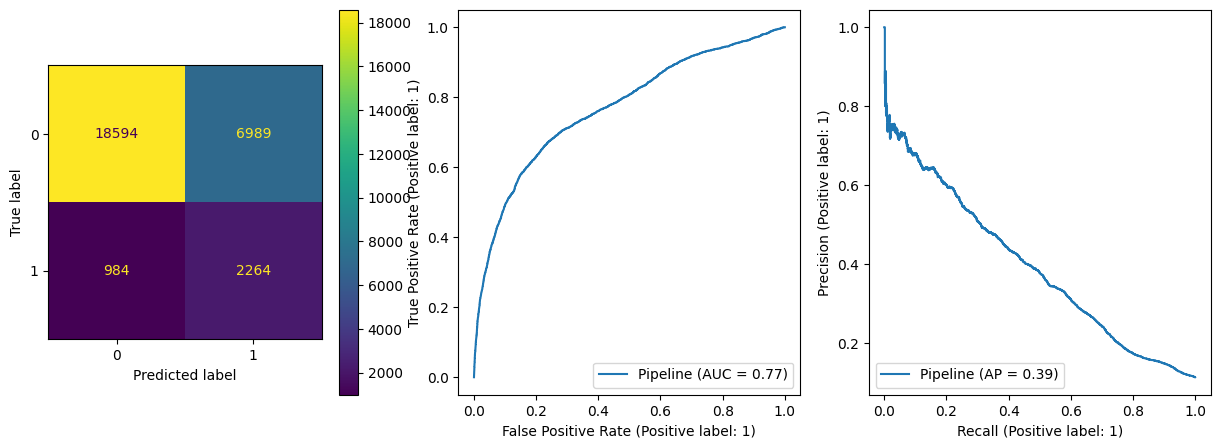

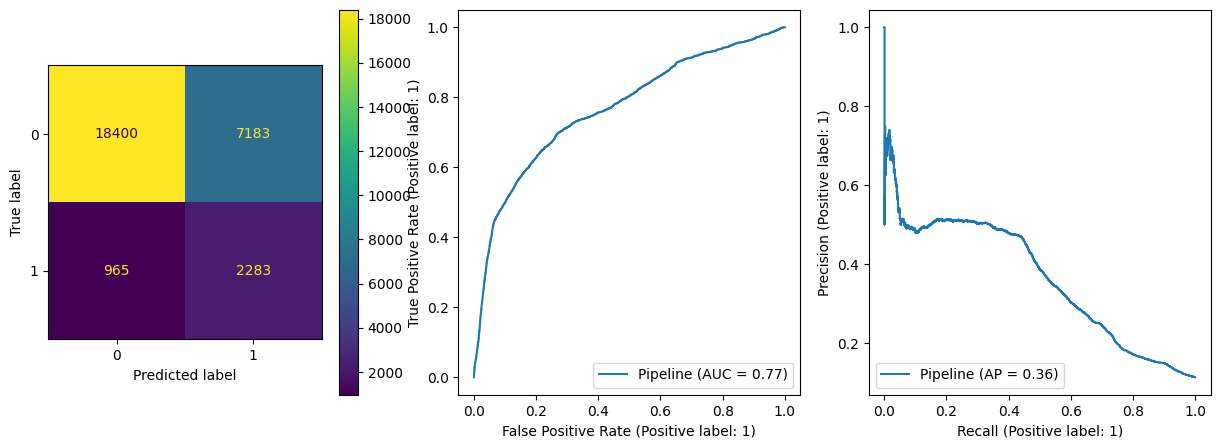

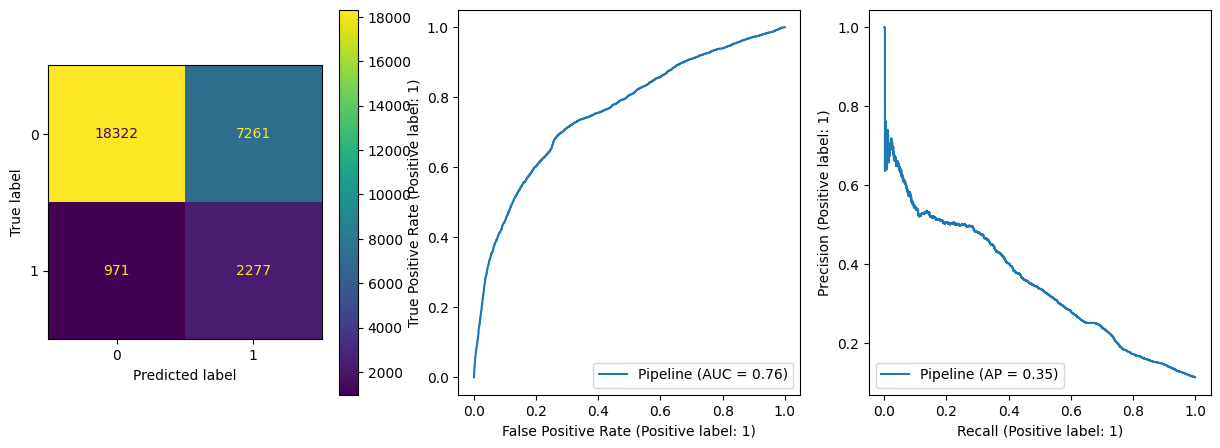

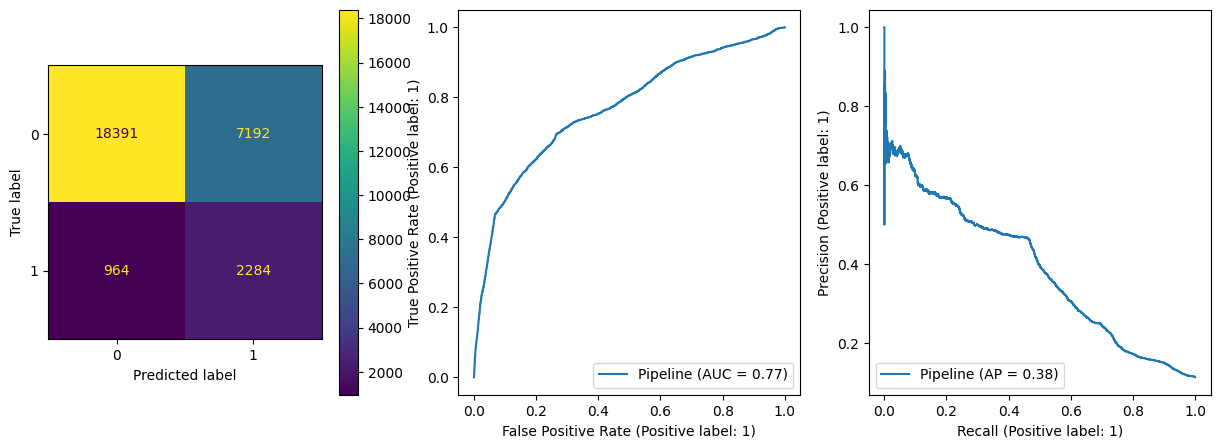

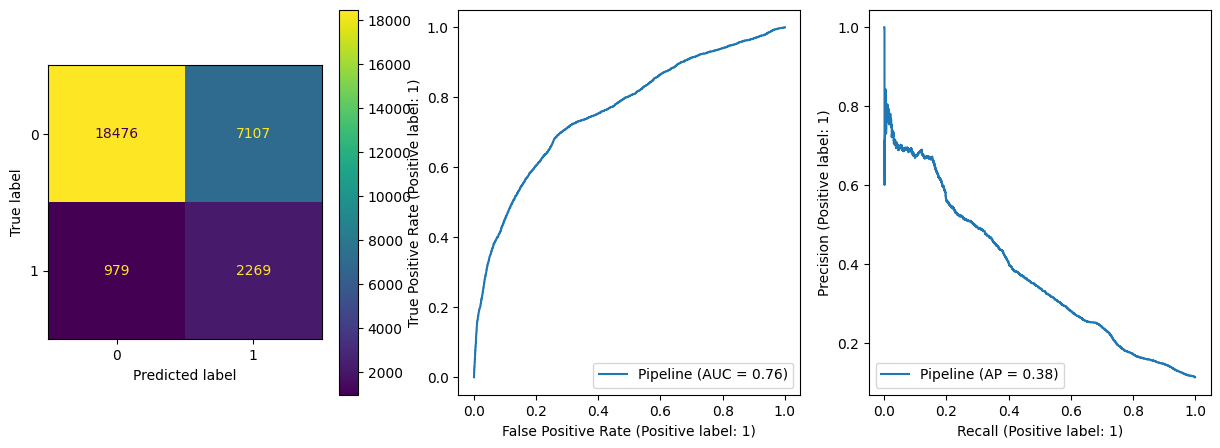

In [37]:
for clf in classifiers:
    for pl in tqdm(pipelines):
        X_train, y_train = preprocess_data(df, pipeline=pl[1], fit=True)
        for col in X_train.select_dtypes(include=['object', 'category']).columns:
            X_train[col] = pd.to_numeric(X_train[col])
        if len(X_train.select_dtypes(include=['object', 'category']).columns) > 0:
            raise ValueError('Some columns have non-numerical type')
        clf.fit(X_train, y_train)
        res = show_model_results(classifier, train_set=[X_train, y_train])
        results_df.append(
            type='LogisticRegression',
            params=str(clf['clf'].get_params()),
            accuracy=res['accuracy'],
            recall=res['recall'],
            precision=res['precision'],
            auc=res['auc'],
            preproc_descr=pl[0]
        )
results_df._df

In [38]:
results_df.save()

True

In [26]:
param_grid = [
    dict(clf__C=np.logspace(-4, 1, 10), clf__solver=['lbfgs', 'newton-cg', 'sag'], clf__penalty=['l2'], ),
    dict(clf__C=np.logspace(-4, 1, 10), clf__solver=['liblinear'], clf__penalty=['l1','l2'], ),
    dict(clf__C=np.logspace(-4, 1, 10), clf__solver=['saga'], clf__penalty=['l1','l2', 'elasticnet'], ),
]

In [27]:
lr_grid_smote = GridSearchCV(
    estimator=lr_smote,
    param_grid=param_grid,
    cv=kfold,
    return_train_score=True,
    scoring=scoring,
    refit='Recall'
)

In [28]:
lr_grid_smote.fit(X_train, y_train)

d:\Work\venv\dsml\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Work\venv\dsml\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Work\venv\dsml\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "d:\Work\venv\dsml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_rat

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('upsample', SMOTE(random_state=42)),
                                       ('clf', LogisticRegression())]),
             param_grid=[{'clf__C': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940...
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']},
                         {'clf__C': array([1.00000000e-04, 3.59381366e-04, 1.29154967e-03, 4.64158883e-03,
       1.66810054e-02, 5.99484250e-02, 2.15443469e-01, 7.74263683e-01,
       2.78255940e+00, 1.00000000e+01]),
                          'clf__penalty': ['l1', 'l2', 'elasticnet'],
                          'clf__solver': ['saga']}],
             refit='Recall', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Recall': 'recall'})

In [29]:
lr_grid_smote.best_estimator_

Pipeline(steps=[('scale', MinMaxScaler()), ('upsample', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.001291549665014884, penalty='l1',
                                    solver='saga'))])

Scores:
Indicator  	Train 	Test
Accuracy:  	0.7168 	0.7250
Precision: 	0.2409 	0.2520
Recall:    	0.7035 	0.7320
F1:        	0.3589 	0.3749


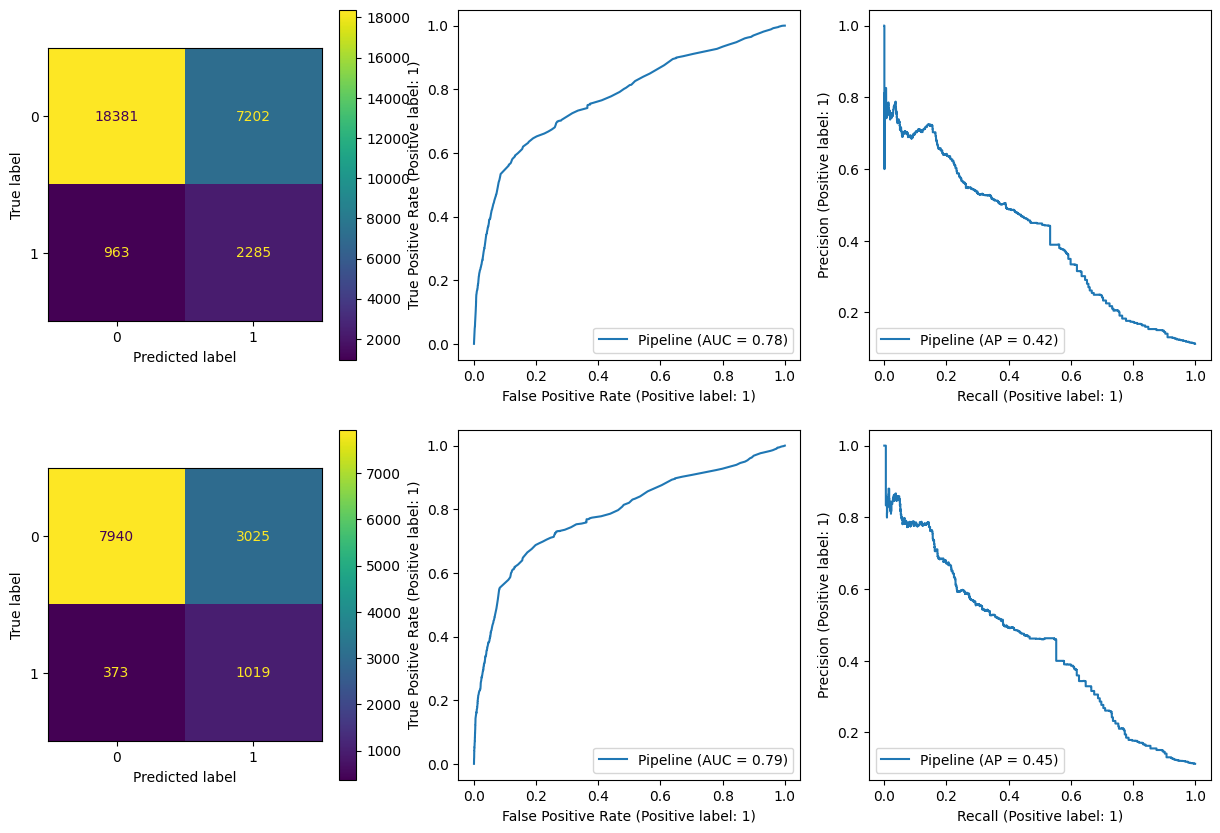

In [30]:
show_model_results(lr_grid_smote.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test])

In [31]:
lr_grid_smote.predict_proba(X_train[:5])

array([[0.69446246, 0.30553754],
       [0.69438109, 0.30561891],
       [0.40173067, 0.59826933],
       [0.71277015, 0.28722985],
       [0.40274481, 0.59725519]])

In [32]:
lr_grid_smote.decision_function(X_train[:5])

array([-0.82106545, -0.82068201,  0.39825915, -0.90887624,  0.39404135])

In [33]:
1 / (1 + np.exp(-lr_grid_smote.decision_function(X_train[:5])))

array([0.30553754, 0.30561891, 0.59826933, 0.28722985, 0.59725519])

In [34]:
lr_grid_smote.best_estimator_['clf'].get_params()

{'C': 0.001291549665014884,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
fpr, tpr, thresholds = roc_curve(y_train, lr_grid_smote.best_estimator_.predict_proba(X_train)[:, 1], drop_intermediate=False)

Method of finding optimal threshold value through |tpr + fpr - 1| -> min was found [here](https://medium.com/@data.science.enthusiast/find-optimal-decision-threshold-for-a-logistic-regression-model-in-fintech-dataset-b060f0182830#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImEyOWFiYzE5YmUyN2ZiNDE1MWFhNDMxZTk0ZmEzNjgwYWU0NThkYTUiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NzI4MzkwMTEsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwNjMyNDk1NDA2NDYzMzQ4MDk4MCIsImVtYWlsIjoic2hhcnVoaW5kYUBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiYXpwIjoiMjE2Mjk2MDM1ODM0LWsxazZxZTA2MHMydHAyYTJqYW00bGpkY21zMDBzdHRnLmFwcHMuZ29vZ2xldXNlcmNvbnRlbnQuY29tIiwibmFtZSI6IkRtaXRyeSBTaGFydWtoaW4iLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUVkRlRwNVJDZDZWTThtR19UNXQ1YzlBWEtiSDZRbUkwYjRlbUpaTnFqXzdqQT1zOTYtYyIsImdpdmVuX25hbWUiOiJEbWl0cnkiLCJmYW1pbHlfbmFtZSI6IlNoYXJ1a2hpbiIsImlhdCI6MTY3MjgzOTMxMSwiZXhwIjoxNjcyODQyOTExLCJqdGkiOiIxYzdjMTkwN2U4M2M4NGFjODdkYTY3ZGU4NDY2OGIyYTZkNDYyYTZjIn0.EdlX61UWFmeXsgXDvYRr-r6pmlUWrRLEnAf33H0FeVTugXWOVtNAfgbUfJV20C3kk7qZce2f21J5ATjUOqsBc5xpLjZlOkA0I-I60dyxdGdFasxHDYoF-FBZ3rwiuMoWt5HZQHZVLbJ_wMRXR901ZD1NTEFy-8fz5BT0qSe0O6F45yWrBbKHGbuplzTTA46a-WChr_P38JGKTQ3epoLowOp0oDTlWuVkPobvfdnQryJsiN9FdWyYjpwNyoKGdQdaMNhJn9hBHzweStJcoXs8sSOaIIoS2YcjDlWmefzWy4GH3LRL2xHY6YXg9ZuB4H9ZmAuuSIWYROSXUAuFjfCcdw)  
Using tpr-fpr -> max is mine. The logic behind it is that ideal model have tpr->1 and fpr->0 => (1-fpr)->1 => tpr+(1-fpr)->2 => tpr-fpr -> max

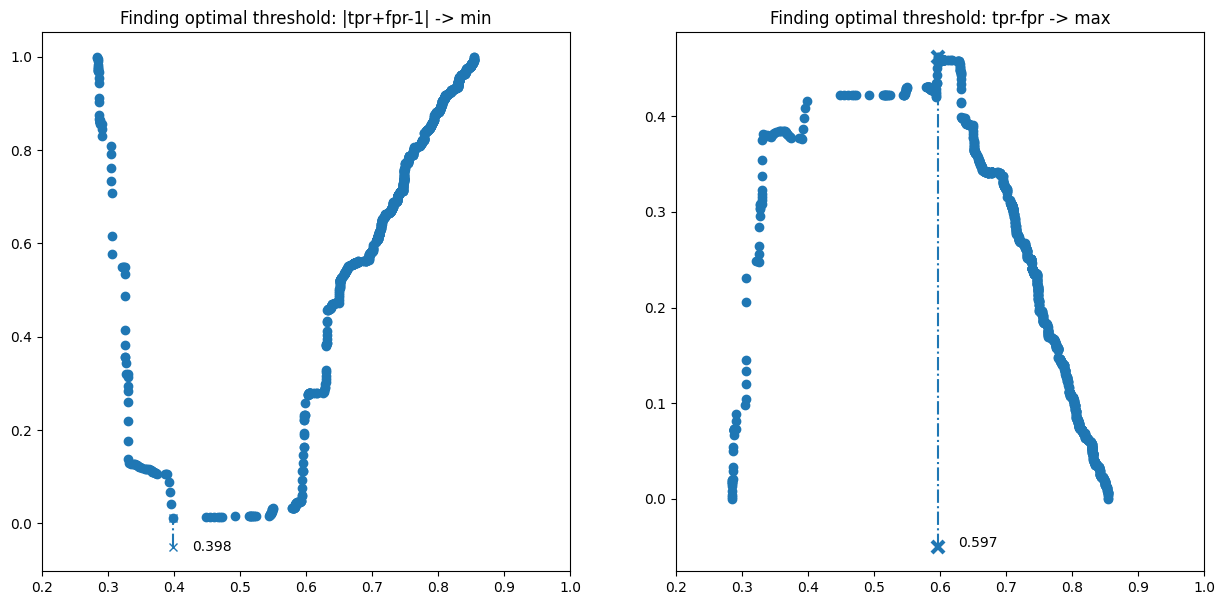

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

a1 = np.abs(fpr + tpr - 1)
best_index = np.nonzero(a1 == a1.min())[0]
best_thresh_val = thresholds[best_index][0]
axs[0].scatter(thresholds, np.abs(a1))
axs[0].plot([thresholds[best_index]]*2, [-0.05, a1.min()], linestyle='-.', marker='x', markeredgewidth=3)
axs[0].set_title('Finding optimal threshold: |tpr+fpr-1| -> min')
axs[0].annotate('{:.3f}'.format(best_thresh_val), xy=(thresholds[best_index]+0.03, -0.06))

a = tpr - fpr
best_index = np.nonzero(a == a.max())[0]
best_thresh_val = thresholds[best_index][0]
axs[1].scatter(thresholds, a)
axs[1].plot([thresholds[best_index]]*2, [-0.05, a.max()], linestyle='-.', marker='x', markeredgewidth=3, ms=8)
axs[1].set_title('Finding optimal threshold: tpr-fpr -> max')
axs[1].annotate('{:.3f}'.format(best_thresh_val), xy=(thresholds[best_index]+0.03, -0.05))
axs[1].set_xbound(lower=0.2, upper=1.0)

Now we can compare thresholds found with 1st and 2nd method and see what values metrics havein each case. As both models are aimed to find more minor positives, 'recall' metric will be used

In [37]:
thresholds

array([1.85433221, 0.85433221, 0.85428448, ..., 0.2845267 , 0.28440963,
       0.28433159])

In [38]:
thresh_val = 0.5
y_pred_decision = lr_grid_smote.decision_function(X_train)
print(y_train.shape, y_pred_decision.shape)

(28831,) (28831,)


In [39]:
print(y_pred_decision.min(), y_pred_decision.max())

-0.9230757945928578 1.768991492947079


In [41]:
idx_min = np.nonzero(y_pred_decision == y_pred_decision.min())
idx_max = np.nonzero(y_pred_decision == y_pred_decision.max())
print(idx_min, idx_max)

(array([  302,   665,  1071,  1111,  1322,  2796,  4055,  4068,  4190,
        5259,  5897,  5918,  8535,  8603,  8941,  8989,  9975, 10019,
       10329, 10947, 10982, 11426, 11560, 12027, 12164, 12533, 12591,
       12890, 13814, 14886, 16170, 16477, 17680, 18466, 18504, 18596,
       18970, 19304, 19438, 19526, 19582, 19942, 20567, 21490, 21704,
       22819, 23906, 24077, 24301, 24610, 24633, 24835, 24952, 25105,
       25338, 26524, 26983, 27530, 27940, 28077], dtype=int64),) (array([8345], dtype=int64),)


In [48]:
y_pred_proba = lr_grid_smote.predict_proba(X_train)[:, 1]
y_pred_proba

array([0.30553754, 0.30561891, 0.59826933, ..., 0.28722985, 0.59656325,
       0.2872691 ])

In [49]:
y_pred = lr_grid_smote.predict(X_train)
y_pred

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [50]:
min_pos_proba = y_pred_proba[y_pred == 1].min()
max_neg_proba = y_pred_proba[y_pred == 0].max()
print(min_pos_proba, max_neg_proba)

0.514417426476616 0.492354185298638


In [54]:
y_pred_thresh = y_pred_proba >= 0.5
(y_pred_thresh == y_pred).sum() == y_pred.shape[0]

True

In [65]:
np.int8(y_pred_thresh)

array([0, 0, 1, ..., 0, 1, 0], dtype=int8)

In [61]:
y_train[(y_train == 0) & (y_pred_thresh == y_train)].count() # TN
y_train[(y_train == 1) & (y_pred_thresh == y_train)].count() # TP
y_train[(y_train == 0) & (y_pred_thresh != y_train)].count() # FP
y_train[(y_train == 1) & (y_pred_thresh != y_train)].count() # FN

963

In [78]:
print('Threshold \tRecall \tPrecision \tFP quantity \tFP/FN')
for thresh_val in np.arange(0.39, 0.41, 0.001):
    y_pred_thresh = np.int8(y_pred_proba >= thresh_val)
    tp = y_train[(y_train==1) & (y_pred_thresh==1)].count()
    fn = y_train[(y_train==1) & (y_pred_thresh==0)].count()
    fp = y_train[(y_train==0) & (y_pred_thresh==1)].count()
    print('{:.3f} \t{:.3f} \t{:.3f} \t{} \t{:.3f}'.format(thresh_val, tp/(tp+fn), tp/(tp+fp), fp, fp/fn))
print('-'*20)
for thresh_val in np.arange(0.59, 0.61, 0.001):
    y_pred_thresh = np.int8(y_pred_proba >= thresh_val)
    tp = y_train[(y_train==1) & (y_pred_thresh==1)].count()
    fn = y_train[(y_train==1) & (y_pred_thresh==0)].count()
    fp = y_train[(y_train==0) & (y_pred_thresh==1)].count()
    print('{:.3f} \t{:.3f} \t{:.3f} \t{} \t{:.3f}'.format(thresh_val, tp/(tp+fn), tp/(tp+fp), fp, fp/fn))

Threshold 	Recall 	Precision 	FP quantity 	FP/FN
0.390 	0.741 	0.205 	9330 	11.094
0.391 	0.737 	0.211 	8980 	10.528
0.392 	0.737 	0.211 	8980 	10.528
0.393 	0.733 	0.218 	8559 	9.872
0.394 	0.725 	0.225 	8089 	9.048
0.395 	0.725 	0.225 	8089 	9.048
0.396 	0.713 	0.233 	7609 	8.173
0.397 	0.713 	0.233 	7609 	8.173
0.398 	0.713 	0.233 	7609 	8.173
0.399 	0.704 	0.241 	7208 	7.493
0.400 	0.704 	0.241 	7208 	7.493
0.401 	0.704 	0.241 	7208 	7.493
0.402 	0.704 	0.241 	7208 	7.493
0.403 	0.704 	0.241 	7208 	7.493
0.404 	0.704 	0.241 	7208 	7.493
0.405 	0.704 	0.241 	7208 	7.493
0.406 	0.704 	0.241 	7208 	7.493
0.407 	0.704 	0.241 	7208 	7.493
0.408 	0.704 	0.241 	7208 	7.493
0.409 	0.704 	0.241 	7208 	7.493
--------------------
0.590 	0.690 	0.250 	6738 	6.691
0.591 	0.689 	0.249 	6736 	6.676
0.592 	0.689 	0.249 	6734 	6.661
0.593 	0.688 	0.249 	6733 	6.653
0.594 	0.674 	0.254 	6413 	6.056
0.595 	0.661 	0.270 	5793 	5.262
0.596 	0.652 	0.291 	5165 	4.571
0.597 	0.635 	0.314 	4509 	3.802
0.5

In [ ]:
"""
{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}
"""

if every 'yes' brings us $10 and 1 call costs $1 then  
revenue = $10 * tp
revenue_lost = $10 * fn
cost = $1 * (tp+fp)
profit = revenue - cost

In [169]:
# slower version (~200 ms)
thresh_vals = np.arange(0.2, 0.9, 0.005)
revenue_per1 = 10.0
cost_per1 = 1.0
revenue = []
revenue_lost = []
cost = []
recall = []
precision = []
tp_arr = []
for thresh_val in thresh_vals:
    y_pred = np.int8(y_pred_proba >= thresh_val)
    tp = y_train[(y_train==1)&(y_pred==1)].count()
    fp = y_train[(y_train==0)&(y_pred==1)].count()
    fn = y_train[(y_train==1)&(y_pred==0)].count()
    revenue.append(revenue_per1*tp)
    revenue_lost.append(revenue_per1*fn)
    cost.append(cost_per1*(tp+fp))
    recall.append(tp/(tp+fn))
    precision.append(tp/(tp+fp))
    tp_arr.append(tp)

<magic-timeit>:19: RuntimeWarning: invalid value encountered in longlong_scalars


218 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [124]:
np.nonzero(np.round(thresh_vals, 3) == 0.5)

(array([60], dtype=int64),)

In [101]:
y_pred_proba

array([[0.30553754],
       [0.30561891],
       [0.59826933],
       ...,
       [0.28722985],
       [0.59656325],
       [0.2872691 ]])

In [134]:
np.array_equal(np.int8(y_pred_proba.reshape(-1, 1) >= thresh_vals)[:, 60], np.int8(y_pred_proba >= 0.5))

True

In [141]:
y_train.shape

(28831,)

In [170]:
# faster version (~50 ms)
# create matrix of shape (n_observations, n_threshold_values) with values 1 or 0 for probability >= threshold or < threshold respectively
# y_pred_proba is vector of shape (n_observations,) containing probabilities of positive class predicted by model
# thresh_vals is vector of shape (n_threshold_values,) containing equally distributed threshold values in defined range
y_pred_matrix = np.int8(y_pred_proba.reshape(-1, 1) >= thresh_vals)
tp_matrix = ((y_pred_matrix == 1) & (y_train.to_numpy().reshape(-1, 1) == 1)).sum(axis=0) # => vector of shape (n_threshold_values,) with number of records in each column that meet the condition
fp_matrix = ((y_pred_matrix == 1) & (y_train.to_numpy().reshape(-1, 1) == 0)).sum(axis=0)
fn_matrix = ((y_pred_matrix == 0) & (y_train.to_numpy().reshape(-1, 1) == 1)).sum(axis=0)
revenue_matrix = tp_matrix * revenue_per1 # => performs element-wise operations on array
cost_matrix = (tp_matrix + fp_matrix) * cost_per1
revenue_lost_matrix = fn_matrix * revenue_per1
recall_matrix = tp_matrix / (tp_matrix + fn_matrix) # => performs element-wise operations on arrays of the same shape
precision_matrix = tp_matrix / (tp_matrix + fp_matrix)

<magic-timeit>:9: RuntimeWarning: invalid value encountered in divide


49.5 ms ± 7.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [168]:
np.array_equal(np.array(recall), recall_matrix)

True

In [98]:
y_train.to_numpy().reshape(-1, 1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

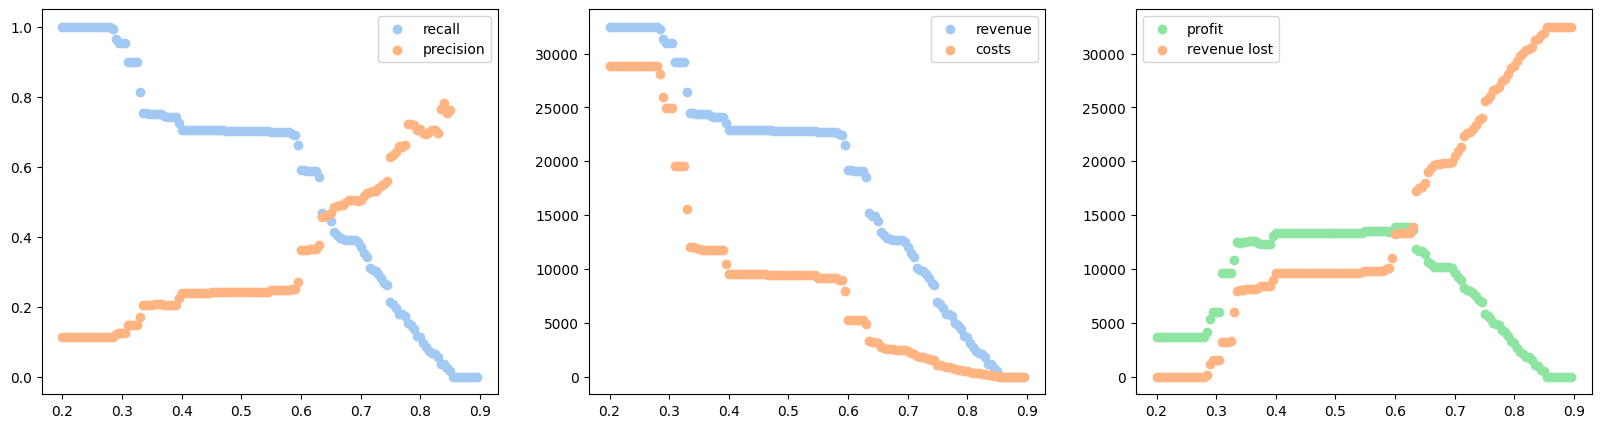

In [137]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
axs[0].scatter(x=thresh_vals, y=recall, color=sns.color_palette('pastel', as_cmap=True)[0], label='recall')
axs[0].scatter(x=thresh_vals, y=precision, color=sns.color_palette('pastel', as_cmap=True)[1], label='precision')
axs[0].legend()
axs[1].scatter(x=thresh_vals, y=revenue, color=sns.color_palette('pastel', as_cmap=True)[0], label='revenue')
axs[1].scatter(x=thresh_vals, y=cost, color=sns.color_palette('pastel', as_cmap=True)[1], label='costs')
axs[1].legend()
axs[2].scatter(x=thresh_vals, y=np.array(revenue)-np.array(cost), color=sns.color_palette('pastel', as_cmap=True)[2], label='profit')
axs[2].scatter(x=thresh_vals, y=revenue_lost, color=sns.color_palette('pastel', as_cmap=True)[1], label='revenue lost')
axs[2].legend()

Probability Calibration